## Initial Setup for FashionMNIST DCGAN

- **Device Setup**: Automatically selects GPU if available for faster processing.
- **Data Preprocessing**: Includes normalization and conversion of FashionMNIST images to tensors.
- **Dataset and DataLoader**: Loads FashionMNIST with transformations, using a DataLoader for efficient batch and shuffle operations.

This setup prepares the environment for training a DCGAN to generate realistic clothing images.


In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations for the input data: convert to tensor and normalize it
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 12170866.28it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 204393.29it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3780295.92it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 3743459.95it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



## Discriminator and Generator Classes for DCGAN

- **Discriminator Class**: Defines a neural network that classifies images as real or synthetic. It includes convolutional layers for feature extraction, followed by dropout layers for regularization, and a linear output layer with a sigmoid activation to output a probability.

- **Generator Class**: Constructs synthetic images from random noise vectors. The network uses a series of transpose convolutional layers (also known as deconvolutional layers) to upsample the input noise vector to the size of an image, with batch normalization and LeakyReLU activations to stabilize the training.


These classes are central to the GAN architecture, where the generator learns to create increasingly realistic images, while the discriminator improves its ability to distinguish fake images from real ones.


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # Configure the discriminator layers
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 5, stride=2, padding=2),
            nn.LeakyReLU(0.3),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, 5, stride=2, padding=2),
            nn.LeakyReLU(0.3),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(128*7*7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Configure the Generator layers
        self.model = nn.Sequential(
            nn.Linear(100, 7*7*256, bias=False),
            nn.BatchNorm1d(7*7*256),
            nn.LeakyReLU(0.3),
            nn.Unflatten(1, (256, 7, 7)),
            nn.ConvTranspose2d(256, 128, 5, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.3),
            nn.ConvTranspose2d(128, 64, 5, stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.3),
            nn.ConvTranspose2d(64, 1, 5, stride=2, padding=2, output_padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Initialize and assign models to the device
D = Discriminator().to(device)
G = Generator().to(device)

## GAN Training Configuration and Execution

- **Optimizers**: Initializes Adam optimizers for both the discriminator (`D`) and generator (`G`) with a learning rate of 10^{-4}.

- **Loss Function**: Implements Binary Cross-Entropy Loss (`BCELoss`) to evaluate the accuracy of the discriminator and the efficacy of the generator.

- **Image Saving Function**: Defines `save_fake_images`, which periodically saves generated images to visualize the generator's progress at key epochs (10, 30, 50).

- **Training Loop**:
  - Trains the discriminator to distinguish real from fake images.
  - Optimizes the generator to fool the discriminator into mistaking fake images for real ones.
  - Records and prints losses for each epoch to monitor training progress.

- **Loss Tracking**: Collects and logs the discriminator and generator losses throughout the training, aiding in performance evaluation.

This streamlined setup ensures efficient tracking of training dynamics and facilitates periodic evaluation of the generator's image output quality.

In [ ]:
# Initialize optimizers
optimizerD = optim.Adam(D.parameters(), lr=1e-4)
optimizerG = optim.Adam(G.parameters(), lr=1e-4)

criterion = nn.BCELoss()

def save_fake_images(epoch):
    os.makedirs('outputs', exist_ok=True)
    fixed_noise = torch.randn(32, 100, device=device)
    fake_images = G(fixed_noise).detach().cpu()
    save_image(fake_images, f'outputs/epoch_{epoch}.png', nrow=8, normalize=True)

# Training parameters
num_epochs = 50
d_losses = []
g_losses = []

for epoch in range(num_epochs):
    d_loss_total = 0.0
    g_loss_total = 0.0
    for i, (images, _) in enumerate(train_loader):
        real_images = images.to(device)
        real_labels = torch.ones(images.size(0), 1, device=device)
        fake_labels = torch.zeros(images.size(0), 1, device=device)

        D.zero_grad()
        outputs = D(real_images)
        d_loss_real = criterion(outputs, real_labels)
        d_loss_real.backward()

        noise = torch.randn(images.size(0), 100, device=device)
        fake_images = G(noise)
        outputs = D(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        d_loss_fake.backward()
        optimizerD.step()
        d_loss_total += d_loss_real.item() + d_loss_fake.item()

        G.zero_grad()
        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        optimizerG.step()
        g_loss_total += g_loss.item()

    # Update losses
    d_losses.append(d_loss_total / len(train_loader))
    g_losses.append(g_loss_total / len(train_loader))

    # Record and print losses
    print(f'Epoch [{epoch + 1}/{num_epochs}], d_loss: {d_losses[-1]:.4f}, g_loss: {g_losses[-1]:.4f}')

    if (epoch+1) in [10, 30, 50]:
        save_fake_images(epoch+1)

print('Training finished.')

Epoch [1/50], d_loss: 0.8226, g_loss: 1.8954
Epoch [2/50], d_loss: 1.0060, g_loss: 1.4623
Epoch [3/50], d_loss: 0.9073, g_loss: 1.5867
Epoch [4/50], d_loss: 0.8061, g_loss: 1.7381
Epoch [5/50], d_loss: 0.8732, g_loss: 1.6385
Epoch [6/50], d_loss: 0.9313, g_loss: 1.5202
Epoch [7/50], d_loss: 0.9522, g_loss: 1.4357
Epoch [8/50], d_loss: 0.9370, g_loss: 1.4458
Epoch [9/50], d_loss: 0.9607, g_loss: 1.4379
Epoch [10/50], d_loss: 1.0051, g_loss: 1.3294
Epoch [11/50], d_loss: 1.0244, g_loss: 1.3244
Epoch [12/50], d_loss: 1.0652, g_loss: 1.2475
Epoch [13/50], d_loss: 1.0975, g_loss: 1.1936
Epoch [14/50], d_loss: 1.1189, g_loss: 1.1537
Epoch [15/50], d_loss: 1.1330, g_loss: 1.1215
Epoch [16/50], d_loss: 1.1501, g_loss: 1.0978
Epoch [17/50], d_loss: 1.1112, g_loss: 1.2053
Epoch [18/50], d_loss: 1.0743, g_loss: 1.2959
Epoch [19/50], d_loss: 1.1625, g_loss: 1.0785
Epoch [20/50], d_loss: 1.1710, g_loss: 1.0571
Epoch [21/50], d_loss: 1.1837, g_loss: 1.0423
Epoch [22/50], d_loss: 1.1890, g_loss: 1.02

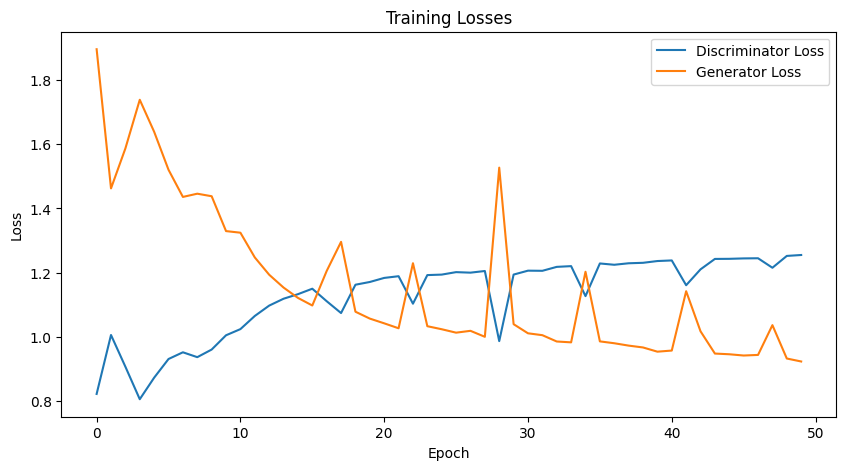

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()

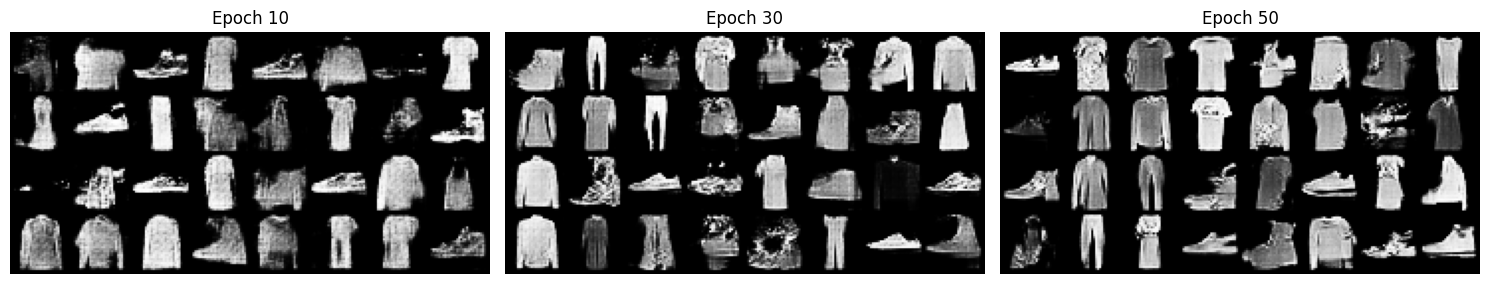

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import glob

def load_and_display_images_from_folder(folder_path='outputs', image_format='png'):
    if not os.path.exists(folder_path):
        print("Folder not found:", folder_path)
        return

    image_files = sorted(glob.glob(f'{folder_path}/*.{image_format}'), key=os.path.getmtime)

    num_images = len(image_files)
    if num_images == 0:
        print("No images found in the folder")
        return

    cols = 3
    rows = (num_images + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    axes = axes.flatten()

    for ax, img_path in zip(axes, image_files):
        img = Image.open(img_path)
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        epoch_number = os.path.basename(img_path).split('_')[1].split('.')[0]
        ax.set_title(f'Epoch {epoch_number}')

    for ax in axes[len(image_files):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

load_and_display_images_from_folder()


## Results and Observations from GAN Training

- **Discriminator and Generator Losses**: Throughout the training, discriminator losses gradually increased, suggesting challenges in distinguishing between real and fake images as the generator improved. Conversely, generator losses decreased, indicating its growing proficiency in creating realistic images.

- **Image Quality Progression**: Images saved at epochs 10, 30, and 50 showed visible improvements:
  - **Epoch 10**: Images were blurry and lacked detail.
  - **Epoch 30**: Notable improvements in clarity and texture, though still lacking in some aspects of realism.
  - **Epoch 50**: Significant enhancements in image quality, with much clearer and more detailed representations of fashion items.

- **Conclusion**: The training demonstrates effective learning by the generator, as evidenced by the increased difficulty for the discriminator and the qualitative improvements in the generated images. Continued training and potential model tweaks could yield even more realistic results.

This analysis indicates a successful training direction, with potential areas for further optimization and refinement to enhance the model's performance.
